In [20]:
# Import train_test_split function
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# import warnings filter to ignore all future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) 

In [3]:
#read telemetry data
df = pd.read_csv("/Users/md.kamal/Downloads/device_failure.csv", encoding = 'unicode_escape')

In [5]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [7]:
df.describe()

,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [22]:
df.groupby('failure')['failure'].count()


failure
0    124388
1       106
Name: failure, dtype: int64

In [28]:
print('Distinct value count: \n')
for col in list(df):
    print(col, ":", len(df[col].unique()))

Distinct value count: 

date : 304
device : 1169
failure : 2
attribute1 : 123877
attribute2 : 558
attribute3 : 47
attribute4 : 115
attribute5 : 60
attribute6 : 44838
attribute7 : 28
attribute8 : 28
attribute9 : 65


In [13]:
import pandas_profiling 
pandas_profiling.ProfileReport(df)

Number of variables,12
Number of observations,124494
Total Missing (%),0.0%
Total size in memory,11.4 MiB
Average record size in memory,96.0 B
Numeric,8
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,1


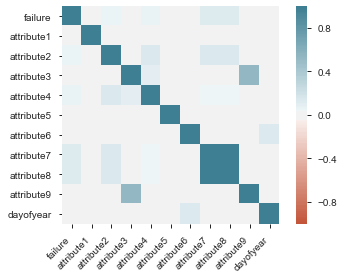

In [63]:
#correlation among attributes with failue
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [445]:
# time difference of the data
df['pd_timestamp'] =pd.to_datetime(df['date'])
df['pd_timestamp'].max() -df['pd_timestamp'].min()

Timedelta('305 days 00:00:00')

In [30]:
# get the day of the year from timestamp 
df['dayofyear'] = df['pd_timestamp'].apply(lambda x: x.dayofyear)

In [155]:
# number of records in different days
num_of_record = df.groupby('dayofyear')['dayofyear'].count()[0:10]
num_of_record

dayofyear
1     1163
2     1163
3     1163
4     1162
5     1161
6     1054
7      798
8      756
9      756
10     755
Name: dayofyear, dtype: int64

# Insights /questions to answer
- some of the devices has more records 
- some of the devices has only 5/6 records
- is the failed devices send more signal?
- is the data points/ telemetry singal consistent ? getting signal in a regular basis


In [147]:
# record per device
record_per_device = df.groupby('device')['device'].count()
record_per_device[record_per_device].sort_values(ascending=False)[0:5]


device
S1F0FP0C    304
S1F0FP0C    304
S1F0FP0C    304
S1F0FP0C    304
S1F0FP0C    304
Name: device, dtype: int64

In [131]:
device_failure = df[df.failure==1].groupby('device')['device'].count()

device_failed_list =df[df.failure==1]['device']
device_failed_df = df[df['device'].isin(device_failed_list)]
print('total record for failed device:', device_failed_df.shape)
print('total record:', len(df))
print( 'failed device count:', len(device_failed_df['device'].unique()))

total record for failed device: (10713, 14)
total record: 124494
failed device count: 106


# Each device failed max 01 times
- ### minimum records for a device is 5 
- ### maximum records for a device is 299 

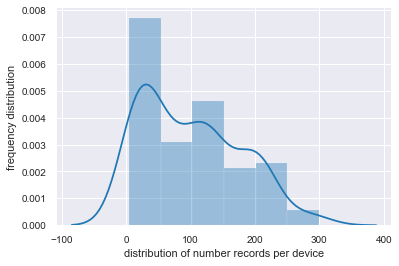

In [140]:
# record per failed device device
record_per_failed_device = device_failed_df.groupby('device')['device'].count()
ax =sns.distplot(record_per_failed_device)

ax.set(xlabel='distribution of number records per device', ylabel='frequency distribution')
plt.show()

In [166]:
# max and min records of a failed device 
record_per_failed_device.sort_values(ascending=False)[0:5]
print('max number of records for failed device: ', record_per_failed_device.max())
print('min number of records for failed device: ', record_per_failed_device.min())
print('median number of records for failed device: ', record_per_failed_device.median())

max number of records for failed device:  299
min number of records for failed device:  5
median number of records for failed device:  92.0


In [160]:
# max number of times a device failed count
# device_failed_df.groupby('device')['failure'].sum().sort_values(ascending=False)[0:5]
device_failed_df.groupby('device')['failure'].sum().max()

1

# To investigate the behavior of failed devices  
- ### attribute 2, 4, 7 and 8 has correlation with failure
- original data are aggregated daily
- there are not much difference one or two days before the device failure
- min record we have is 5 days of sequence data for a failure device

# Hence, the data were aggregated again for 07 days to predict the failure probability within 07 days

In [455]:
#list of failed devices 
print(device_failed_df['device'].unique()[0:5])

['S1F023H2' 'S1F03YZM' 'S1F09DZQ' 'S1F0CTDN' 'S1F0DSTY']


In [456]:
df[df.device=='S1F023H2'].tail(7)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,pd_timestamp
11443,2015-01-13,S1F023H2,0,177478384,0,0,1,19,507971,16,16,3,2015-01-13
12198,2015-01-14,S1F023H2,0,203744280,0,0,1,19,509250,16,16,3,2015-01-14
12914,2015-01-15,S1F023H2,0,222474632,0,0,1,19,510519,16,16,3,2015-01-15
13629,2015-01-16,S1F023H2,0,243825496,0,0,1,19,511783,16,16,3,2015-01-16
14344,2015-01-17,S1F023H2,0,20761856,0,0,1,19,513110,16,16,3,2015-01-17
15059,2015-01-18,S1F023H2,0,41291000,0,0,1,19,513722,16,16,3,2015-01-18
15773,2015-01-19,S1F023H2,1,64499464,0,0,1,19,514661,16,16,3,2015-01-19


In [457]:
df[df.device=='S1F0CTDN'].tail(7)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,pd_timestamp
63,2015-01-01,S1F0CTDN,0,50147888,528,0,4,9,381198,32,32,3,2015-01-01
1226,2015-01-02,S1F0CTDN,0,72104024,528,0,4,9,382459,32,32,3,2015-01-02
2389,2015-01-03,S1F0CTDN,0,91492168,528,0,4,9,383713,32,32,3,2015-01-03
3552,2015-01-04,S1F0CTDN,0,112311608,528,0,4,9,384948,32,32,3,2015-01-04
4713,2015-01-05,S1F0CTDN,0,134261688,528,0,4,9,386214,32,32,3,2015-01-05
5856,2015-01-06,S1F0CTDN,0,159974064,528,0,4,9,387343,32,32,3,2015-01-06
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,32,3,2015-01-07


In [458]:
df[df.device=='Z1F0LVGY'].tail(7)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,pd_timestamp
23526,2015-01-29,Z1F0LVGY,0,115284304,0,0,0,7,320221,24,24,0,2015-01-29
24238,2015-01-30,Z1F0LVGY,0,75400928,0,0,0,7,320221,24,24,0,2015-01-30
24950,2015-01-31,Z1F0LVGY,0,26109808,0,0,0,7,320226,24,24,0,2015-01-31
25662,2015-02-01,Z1F0LVGY,0,22379624,0,0,0,7,320226,24,24,0,2015-02-01
26374,2015-02-02,Z1F0LVGY,0,222708952,0,0,0,7,320226,24,24,0,2015-02-02
27086,2015-02-03,Z1F0LVGY,0,187013784,0,0,0,7,320226,24,24,0,2015-02-03
27798,2015-02-04,Z1F0LVGY,1,184775672,0,0,0,7,320227,24,24,0,2015-02-04


In [459]:
df[df.device=='Z1F148T1'].tail(7)


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,pd_timestamp
70518,2015-04-14,Z1F148T1,0,141054368,0,0,0,8,198466,96,96,0,2015-04-14
70922,2015-04-15,Z1F148T1,0,152826840,0,0,0,8,198466,96,96,0,2015-04-15
71326,2015-04-16,Z1F148T1,0,171971496,0,0,0,8,198466,96,96,0,2015-04-16
71689,2015-04-17,Z1F148T1,0,183377408,0,0,0,8,198466,96,96,0,2015-04-17
72049,2015-04-18,Z1F148T1,0,201716856,0,0,9,8,198466,80,80,0,2015-04-18
72409,2015-04-19,Z1F148T1,0,40510240,0,0,9,8,198466,80,80,0,2015-04-19
72769,2015-04-20,Z1F148T1,1,134062824,0,0,9,8,198466,80,80,0,2015-04-20


In [29]:

df[df.device=='S1F01E6Y'].tail(7)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
32151,2015-02-11,S1F01E6Y,0,57781112,0,0,0,12,259450,0,0,0
32863,2015-02-12,S1F01E6Y,0,182622184,0,0,0,12,259460,0,0,0
33575,2015-02-13,S1F01E6Y,0,79408632,0,0,0,12,259463,0,0,0
34287,2015-02-14,S1F01E6Y,0,83214688,0,0,0,12,259468,0,0,0
34999,2015-02-15,S1F01E6Y,0,227370128,0,0,0,12,259479,0,0,0
35710,2015-02-16,S1F01E6Y,0,182876688,0,0,0,12,259486,0,0,0
36421,2015-02-17,S1F01E6Y,0,147350000,0,0,0,12,259491,0,0,0


In [463]:
#alarm code raised by a device 
alarm =df[df.device=='Z1F148T1'].groupby('attribute6')['attribute6'].count()
alarm.sort_values(ascending=False)


attribute6
198461    68
198466    24
198463     2
189955     1
183748     1
184168     1
185379     1
186541     1
187682     1
188776     1
191575     1
191120     1
192683     1
193868     1
195036     1
196117     1
197244     1
198404     1
182606     1
Name: attribute6, dtype: int64

Text(0, 0.5, 'attribute8/ attribute4/ attribute3')

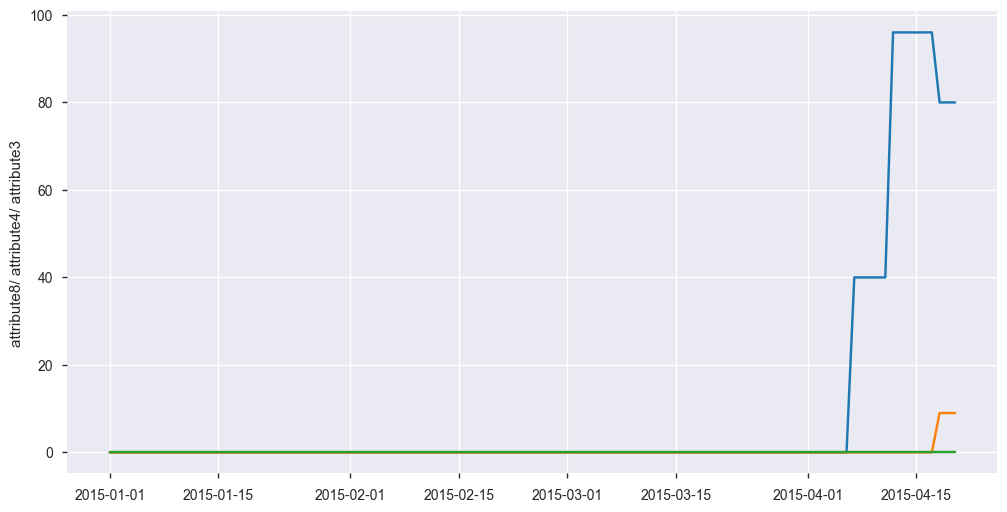

In [464]:
# telemetry singal behavior a device goes down
plt.figure(figsize=(12, 6))
plt.plot(Z1F148T1['pd_timestamp'], Z1F148T1['attribute8'])
plt.plot(Z1F148T1['pd_timestamp'], Z1F148T1['attribute4'])
plt.plot(Z1F148T1['pd_timestamp'], Z1F148T1['attribute3'])
plt.ylabel('attribute8/ attribute4/ attribute3')

# Feature Engineering 
- ### attribute 1, 2 and 6 seems alarm code. Hence, these attributes will be converted into one hot encoding/categorical variables.
- attribute 3,4,5,7,8 and 9 seems numeric (as there is no direct indication about the data feature name). Hence, these attributes were preprocessed as numric values. 
- for failue device, the last record is the one when it failed. Hence, for each device last 07 days records were retrieved for preprocessing

In [4]:
# to get last 07 days data, the processing is done using bigquery 

query = """ select * from
 (
   select *, 
   rank() over( partition by device order by DAYOFYEAR desc) failure_to_days
   FROM `data-services-asia-dev.kamal.device_failure` 
 )
 where failure_to_days <=7 """

from google.cloud import bigquery
last_07_days_df = bigquery.Client().query(query).to_dataframe()
last_07_days_df.head()

/usr/local/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnin

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,DAYOFYEAR,failure_to_days
0,2015-01-06,S1F01085,0,128832128,56,0,52,6,409404,0,0,7,6,1
1,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7,5,2
2,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7,4,3
3,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7,3,4
4,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7,2,5


# # the previous aggregation was done for each device for last 07 days. 
-  
<p style="color:red;"> In this aggregation phase, we sum up the alarms if it was raised for multiple time with 07 days.
 </p>

# creating pipeline 

In [ ]:
def train_n_test_data(df):
    y=df[df.failure_to_days == 1]['failure']  # Labels
    training_X= df.drop(columns=['failure'],  axis=1)
    X = training_X
    return X,y

def print_fn(y_test, y_pred):
    print ('Accuracy:', accuracy_score(y_test, y_pred))
    print ('F1 score:', f1_score(y_test, y_pred))
    print ('Recall:', recall_score(y_test, y_pred))
    print ('Precision:', precision_score(y_test, y_pred))
    print ('\n clasification report:\n', classification_report(y_test, y_pred))
    print ('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

In [5]:
class FeaturesSelector(BaseEstimator, TransformerMixin):
#Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

class NumericalFeatureTransformer( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self ):
        self.aggregation = {
        'attribute3': {
            'attribute3_avg': 'mean',
            'attribute3_max' : 'max',
            'attribute3_min' : 'min',
            'attribute3_median' : 'median'
        }, 
        'attribute4' : {
            'attribute4_avg': 'mean',
            'attribute4_max' : 'max',
            'attribute4_min' : 'min',
            'attribute4_median' : 'median'

        },
        'attribute5' : {
            'attribute5_avg': 'mean',
            'attribute5_max' : 'max',
            'attribute5_min' : 'min',
            'attribute5_median' : 'median'

        },
        'attribute7' : {
            'attribute7_avg': 'mean',
            'attribute7_max' : 'max',
            'attribute7_min' : 'min',
            'attribute7_median' : 'median'

        },
        'attribute8' : {
            'attribute8_avg': 'mean',
            'attribute8_max' : 'max',
            'attribute8_min' : 'min',
            'attribute8_median' : 'median'

        },
        'attribute9' : {
            'attribute9_avg': 'mean',
            'attribute9_max' : 'max',
            'attribute9_min' : 'min',
            'attribute9_median' : 'median'

            }
        } 

    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        agg_numerical_data = X.groupby('device').agg(self.aggregation)
        agg_numerical_data.columns = agg_numerical_data.columns.droplevel()
        return agg_numerical_data
    

class CategoricalFeatureTransformer( BaseEstimator, TransformerMixin ):  
    def __init__( self ):
#         return self
        self._name=0
    
        #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        """
        get dummy variables/ one hot coding for categorical data.
        and then in this aggregation, we sum up the alarms of one hot encoded data,
        if it was raised for multiple time with 07 days 
        """ 
        
        list_of_attribute = list(X)
        list_of_attribute.remove('device')  
        categorical_to_dummy_df =pd.get_dummies(data=X, columns=list_of_attribute).groupby('device').sum()
        return categorical_to_dummy_df
    
class DimensionReduction(BaseEstimator, TransformerMixin):
    def __init__( self, n_components=7 ):
#         return self
        self.n_components=n_components
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        pca = PCA(self.n_components)
        PCA_X = pca.fit_transform(X)
        return PCA_X
    
numerical_features = ['device','attribute3','attribute4','attribute5','attribute7','attribute8', 'attribute9']
categorical_features = ['device','attribute1', 'attribute2','attribute6']

numerical_pipeline = Pipeline(steps=[
    ('feature_selector', FeaturesSelector(numerical_features)),
    ('num_feature_transform', NumericalFeatureTransformer())])

categorical_pipeline = Pipeline(steps=[
    ('feature_selector', FeaturesSelector(categorical_features)),
    ('cat_feature_transform', CategoricalFeatureTransformer())])



#using FeatureUnion
full_pipeline_FeatUnion = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

full_pipeline = Pipeline( steps = [ ( 'Feature_union', full_pipeline_FeatUnion )
                                   , ( 'dimension_reduction', DimensionReduction(n_components=10))] )
 
full_pipeline_rf = Pipeline( steps = [ 
                                    ('rf_classifier', RandomForestClassifier(class_weight=dict({1:10, 0:1})))] )

classifiers = [ 
    RandomForestClassifier(class_weight=dict({1:10, 0:1})),
    XGBClassifier()

]

for classifier in classifiers:
    pipe = Pipeline( steps = [ ('classifier', classifier)] )
    




# Train & Test with default parameters

### dataset is unbalanced
- ### add higher weight to failure device ({1:10,0:1}), class weight 
- ultimate goal of this model building is to predict device failure and reduce maintenance cost. So, high false positive or false negative in both cases, it will increase cost.
- <p style="color:red;"> Hence, it is necessary to have balance/optimize recall and precision value. In a nutshell, F1-score value needs to be maximize to reduce the maintainence cost
 </p>

In [32]:
df_X.shape

(7749, 13)

In [35]:
df_X,y = train_n_test_data(last_07_days_df)
X =full_pipeline.fit_transform(df_X,y) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


for classifier in classifiers:
    print('classifier: ', classifier)
    pipe = Pipeline( steps = [ ('classifier', classifier)] )
    #fit pipeline 
    pipe.fit( X_train, y_train )
    #use pipeline to predict it 
    y_pred = pipe.predict( X_test ) 
    y_pred_proba= pipe.predict_proba( X_test ) 
    print('predicted probability\n', y_pred_proba[0:5])
    print('\n')
    print_fn( y_test,y_pred )

classifier:  RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 10},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)
predicted probability
 [[0.9 0.1]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]
 [1.  0. ]]


Accuracy: 0.9116809116809117
F1 score: 0.47457627118644075
Recall: 0.4666666666666667
Precision: 0.4827586206896552

 clasification report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       321
           1       0.48      0.47      0.47        30

    accuracy                           0.91       351
   macro avg       0.72      0.71      0.71     

# RF hypermater: Bayesian Optimization 

In [19]:
df_X,y = train_n_test_data(last_07_days_df)
X =full_pipeline.fit_transform(df_X,y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
def hyperopt_train_test(params):
    params.update({'class_weight':{1:10, 0:1}})

    clf = RandomForestClassifier(**params)
    y_pred =cross_val_predict(clf, X, y)
    f1_score_fold = f1_score(y, y_pred)
#     return cross_val_score(clf, X, y).mean()
    return f1_score_fold
space4rf = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', range(2,10)),
    'n_estimators': hp.choice('n_estimators', range(1,150)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}
 

def f(params):
    acc = hyperopt_train_test(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=100, trials=trials)
print ('best:', best)

100%|██████████| 100/100 [00:49<00:00,  1.86it/s, best loss: -0.5610859728506787]
best: {'criterion': 1, 'max_depth': 3, 'max_features': 4, 'n_estimators': 60}


#  xgboost hyperparameter: Bayesian Optimization 

In [16]:
df_X,y = train_n_test_data(last_07_days_df)
X =full_pipeline.fit_transform(df_X,y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': hp.choice('max_depth', range(5, 10)),
    'n_estimators': hp.choice('n_estimators', range(5, 100)),
    'num_leaves': hp.choice('num_leaves', range(5, 20)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}


def f(params):
    clf = XGBClassifier(**params)
    params.update({'random_state':6})
    score = cross_val_score(clf, X, y, cv=5).mean()
    y_pred =cross_val_predict(clf, X, y)
    f1_score_fold = f1_score(y, y_pred)
    
    return {'loss': -f1_score_fold, 'status': STATUS_OK}

trials = Trials()
best_param = fmin(f, param_hyperopt, algo=tpe.suggest, max_evals=50, trials=trials, rstate=np.random.RandomState(1))
print('best_param:', best_param)

100%|██████████| 50/50 [00:23<00:00,  2.54it/s, best loss: -0.5276073619631902]
best_param: {'boosting_type': 1, 'colsample_by_tree': 0.9206760293925685, 'learning_rate': 0.20525763991039211, 'max_depth': 4, 'n_estimators': 8, 'num_leaves': 7, 'reg_lambda': 0.9332674147569665}


# RF/xgboost  fit with best parameters from bayesian optimization
- did not train it parameters from bayesian optimization as previous xgboost model is better. 

In [17]:
# best param 
best_param

{'boosting_type': 1,
 'colsample_by_tree': 0.9206760293925685,
 'learning_rate': 0.20525763991039211,
 'max_depth': 4,
 'n_estimators': 8,
 'num_leaves': 7,
 'reg_lambda': 0.9332674147569665}